In [1]:
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

Num GPUs Available:  1


In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
from IPython.display import Image

In [6]:
import os
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
import pathlib
from pathlib import Path
import datetime

## Dive into the data

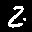

In [8]:
Image(filename = "data/test_data/id_10_label_5.png", width = 32, height = 32)

## A look at the folder content

In [9]:
directory = "./data/train_data"
images = os.listdir(directory)[0:12]

In [10]:
images

['id_2207_label_24.png',
 'id_3835_label_4.png',
 'id_11339_label_18.png',
 'id_13198_label_26.png',
 'id_3256_label_15.png',
 'id_40_label_5.png',
 'id_4101_label_9.png',
 'id_7121_label_23.png',
 'id_4808_label_13.png',
 'id_3739_label_20.png',
 'id_10171_label_12.png',
 'id_154_label_20.png']

## Displaying the data

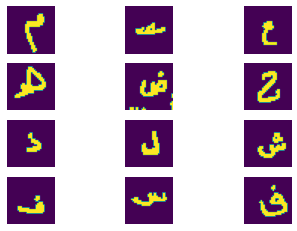

In [11]:
thumbs = [plt.imread(os.path.join(directory,i)) for x, i in enumerate(images)]

fig, axes = plt.subplots(4, 3, sharex=True, sharey=True) 

for img, ax in zip(thumbs, axes.flat):
    ax.imshow(img)
    ax.axis('off')

## Define the data dictionary

In [12]:
arabic_characters = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                    'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                    'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

In [13]:
arabic_char_utf8 = ("أ","ب","ت","ث","ج","ح","خ","د","ذ","ر","ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي")

In [14]:
len(arabic_characters)

28

In [15]:
arabic_characters[12]

'sheen'

In [16]:
arabic_char_utf8[12]

'ش'

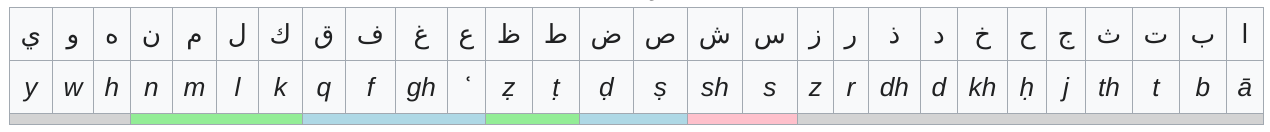

In [17]:
logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [18]:
batch_size = 8
img_height = 32
img_width = 32

def get_dataset(dataset_dir):
    
    def process_filename(file_path):
        label = tf.strings.regex_replace(input=file_path,pattern=r".+_label_(\d+)\.png", rewrite=r"\1")
        label = tf.strings.to_number(label, tf.int32)
        #label = tf.one_hot(label, depth=29)
        return label

    def process_img(file_path):

        img = tf.io.read_file(file_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, size=(32, 32))
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.cast(img, tf.float32) / 255.0
        #img = tf.image.rgb_to_grayscale(img)
        #img = tf.image.convert_image_dtype(img, tf.float32)
        #img = tf.image.resize(img, size=(32, 32))
        return img
    
    data_dir = pathlib.Path(dataset_dir)
    file_list = [str(path.absolute()) for path in Path(data_dir).glob("*.png")]
    files_ds = tf.data.Dataset.from_tensor_slices((file_list))
    files_ds = files_ds.map(lambda x: (process_img(x), process_filename(x)))
    return files_ds

In [19]:
train_dataset_path = "data/train_data"
test_dataset_path = "data/test_data"

train_ds = get_dataset(train_dataset_path).shuffle(buffer_size=batch_size*10).batch(batch_size)
valid_ds = get_dataset(test_dataset_path).batch(batch_size)

In [20]:
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=(32,32,3),
                                        input_tensor=None,
                                        include_top=False,
                                        weights='imagenet')
VGG16_MODEL.trainable=False

# VGG16_MODEL.trainable = True
# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in VGG16_MODEL.layers[:fine_tune_at]:
#   layer.trainable =  False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(29,activation='softmax')

model = tf.keras.Sequential([
  VGG16_MODEL,
  global_average_layer,
  prediction_layer
])



In [21]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 29)                14877     
Total params: 14,729,565
Trainable params: 14,877
Non-trainable params: 14,714,688
_________________________________________________________________


In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [23]:
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         # Stop training when `val_loss` is no longer improving
#         monitor="val_loss",
#         # "no longer improving" being defined as "no better than 1e-2 less"
#         min_delta=1e-2,
#         # "no longer improving" being further defined as "for at least 2 epochs"
#         patience=2,
#         verbose=1,
#     )
# ]
callbacks = [
    tf.keras.callbacks.TensorBoard(
        log_dir=logdir,
        histogram_freq=0,  # How often to log histogram visualizations
        embeddings_freq=0,  # How often to log embedding visualizations
        update_freq="epoch",
    ) 
]

In [24]:
print("Fit model on training data")
history = model.fit(train_ds, epochs = 50, validation_data=valid_ds, callbacks = callbacks)


Fit model on training data
Epoch 1/50
   1/1680 [..............................] - ETA: 0s - loss: 3.3796 - sparse_categorical_accuracy: 0.0000e+00WARNING:tensorflow:From /home/amine/miniconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1680/1680 [==============================] - 16s 10ms/step - loss: 3.1863 - sparse_categorical_accuracy: 0.3126 - val_loss: 3.0812 - val_sparse_categorical_accuracy: 0.4405
Epoch 2/50
1680/1680 [==============================] - 16s 10ms/step - loss: 3.0390 - sparse_categorical_accuracy: 0.4693 - val_loss: 3.0083 - val_sparse_categorical_accuracy: 0.4887
Epoch 3/50
1680/1680 [==============================] - 16s 10ms/step - loss: 2.9838 - sparse_categorical_accuracy: 0.5107 - val_loss: 2.9738 - val_sparse_categorical_accuracy: 0.5116
Epoch 4/50
16

In [25]:
%load_ext tensorboard

In [26]:
logdir

'./logs/20201001-194525'

In [27]:
%tensorboard --logdir $logdir